# Feature selection

Импортируем необходимые библиотеки, считаем данные.

In [1]:
import sys
sys.path.append("./..")

In [2]:
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
%matplotlib inline  

from itertools import chain, combinations

from DecisionTree.GradientTreeBoosting import GradientTreeBoosting
from DecisionTree.DecisionTreeRegressor import DecisionTreeRegressor

In [3]:
HOUSING_DATASET_PATH = "../DataSets/housing.data.txt"

In [4]:
housing_data = np.loadtxt(HOUSING_DATASET_PATH)
np.random.shuffle(housing_data)
x, y = housing_data[::, :-1:], housing_data[::, -1]

In [5]:
first_half = np.array([i < (x.shape[0] / 2) for i in range(x.shape[0])])
x_train, y_train = x[first_half], y[first_half]
x_test, y_test = x[-first_half], y[-first_half]

###Давайте сначала поисследуем полезность фичей для обычного DecisionTree

In [6]:
my_tree = DecisionTreeRegressor()
my_tree.fit(x_train, y_train)
decision_tree_feature_profit = my_tree.get_features_profit(x_train, y_train)
features_tree_sort_order = np.argsort(-decision_tree_feature_profit)
print "Sort indexes: \n %s" % features_tree_sort_order

Sort indexes: 
 [ 5 12  7  0  4 10 11  6  9  8  2  1  3]


In [21]:
tree_error_embedded = np.zeros(features_tree_sort_order.size + 1)
for i in range(1, features_tree_sort_order.size + 1):
    my_tree.fit(x_train[::, features_tree_sort_order[:i]], y_train)
    prediction = my_tree.predict(x_test[::, features_tree_sort_order[:i]])
    tree_error_embedded[i] = sklearn.metrics.mean_squared_error(prediction, y_test)

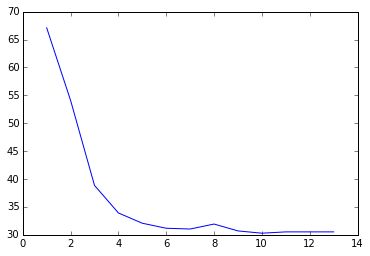

In [22]:
plt.plot([i for i in range(1, tree_error_embedded.size)], tree_error_embedded[1:])
plt.show()

##Посмотрим, как все устроено у бустинга

In [9]:
my_boosting = GradientTreeBoosting(count_steps=200, step=1e-1, max_tree_depth=3)
my_boosting.fit(x_train, y_train)
boosting_features_profit = my_boosting.get_features_profit(x_train, y_train)
features_boosting_sort_order = np.argsort(-decision_tree_feature_profit)
print "Sort indexes: \n %s" % features_tree_sort_order

Sort indexes: 
 [ 5 12  7  0  4 10 11  6  9  8  2  1  3]


In [10]:
boosting_error_embedded = np.zeros(x.shape[1] + 1)
for i in range(1, x.shape[1] + 1):
    my_boosting.fit(x_train[::, features_boosting_sort_order[:i]], y_train)
    prediction = my_boosting.predict(x_test[::, features_boosting_sort_order[:i]])
    boosting_error_embedded[i] = sklearn.metrics.mean_squared_error(prediction, y_test)

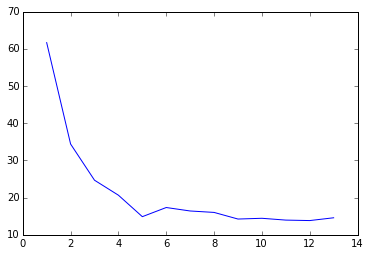

In [11]:
plt.plot([i for i in range(1, boosting_error_embedded.size)], boosting_error_embedded[1:])
plt.show()

##Реализуем CFS

In [12]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [13]:
def get_cfs_optimal_set(x, y, k):
    feature_correlation = np.array([[abs(np.corrcoef(x[::, i], x[::, j])[1][0]) for j in range(x.shape[1])] 
                                                                                  for i in range(x.shape[1])])
    feature_target_correlation = np.array([abs(np.corrcoef(x[::, i], y)[1][0]) for i in range(x.shape[1])])
    
    current_max = 0
    current_subset = list()
    for subset in combinations([i for i in range(x.shape[1])], k):
        numerator = sum(feature_target_correlation[i] for i in subset)
        denumerator = np.sqrt(len(subset) + 2*sum(feature_correlation[i][j] for i, j in combinations(subset, 2)))
        if denumerator > 0 and numerator / denumerator > current_max:
            current_max = numerator / denumerator
            current_subset = subset
    return current_subset

In [14]:
get_cfs_optimal_set(x, y, 3)

(5, 10, 12)

Забавно, что он включает 2 фичи, которые самые полезные согласно нашему embedded методу!

Теперь давайте построим ошибки, которые у нас получаются при отборе фич этим способом.

In [15]:
boosting_error_cfs = np.zeros(x.shape[1] + 1)
tree_error_cfs = np.zeros(x.shape[1] + 1)
for k in range(1, x.shape[1] + 1):
    optimal_k_set = get_cfs_optimal_set(x_train, y_train, k)
    # boosting
    my_boosting.fit(x_train[::, optimal_k_set], y_train)
    prediction = my_boosting.predict(x_test[::, optimal_k_set])
    boosting_error_cfs[k] = sklearn.metrics.mean_squared_error(prediction, y_test)
    
    # tree
    my_tree.fit(x_train[::, optimal_k_set], y_train)
    prediction = my_tree.predict(x_test[::, optimal_k_set])
    tree_error_cfs[k] = sklearn.metrics.mean_squared_error(prediction, y_test)

##Теперь для чистоты эксперимента рандом

In [16]:
random_order = np.array([i for i in range(x.shape[1])])
np.random.shuffle(random_order)

boosting_error_random = np.zeros(x.shape[1] + 1)
tree_error_random = np.zeros(x.shape[1] + 1)
for k in range(1, x.shape[1] + 1):
    current_k_set = random_order[:k]
    # boosting
    my_boosting.fit(x_train[::, current_k_set], y_train)
    prediction = my_boosting.predict(x_test[::, current_k_set])
    boosting_error_random[k] = sklearn.metrics.mean_squared_error(prediction, y_test)
    
    # tree
    my_tree.fit(x_train[::, current_k_set], y_train)
    prediction = my_tree.predict(x_test[::, current_k_set])
    tree_error_random[k] = sklearn.metrics.mean_squared_error(prediction, y_test)

##Теперь построим графики отдельно для дерева и для бустинга, посмотрим как оно вместе

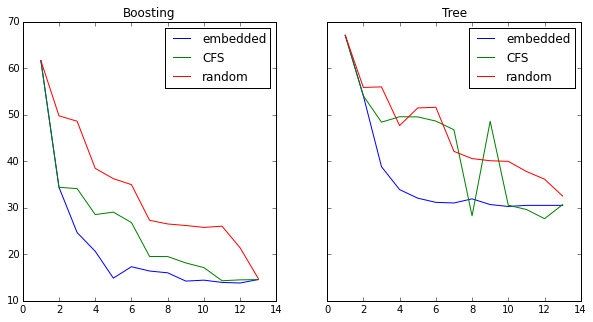

In [23]:
f, axarr = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axarr[0].plot([i for i in range(1, boosting_error_embedded.size)], boosting_error_embedded[1:], label="embedded")
axarr[0].plot([i for i in range(1, boosting_error_cfs.size)], boosting_error_cfs[1:], label="CFS")
axarr[0].plot([i for i in range(1, boosting_error_random.size)], boosting_error_random[1:], label="random")
axarr[0].set_title('Boosting')
axarr[0].legend()
axarr[1].plot([i for i in range(1, tree_error_embedded.size)], tree_error_embedded[1:], label="embedded")
axarr[1].plot([i for i in range(1, tree_error_cfs.size)], tree_error_cfs[1:], label="CFS")
axarr[1].plot([i for i in range(1, tree_error_random.size)], tree_error_random[1:], label="random")
axarr[1].set_title('Tree')
axarr[1].legend()
f.show()